# Eddy Kinetic Energy (EKE) using POP data and applying GCM-filters (with scalar Laplacians)

### Importing packages and the dataset

In [1]:
from intake import open_catalog
import cf_xarray
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
list(cat)

['CESM_POP_hires_control', 'CESM_POP_hires_RCP8_5']

In [2]:
ds = cat['CESM_POP_hires_RCP8_5'].to_dask()

In [3]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 16401, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  3535200
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2016-05-17 at 03:29:14.8
    tavg_sum:      86399.99999999999
    title:         BRCP85C5CN_ne120_t12_pop62.c13b17.asdphys.001

Creating a wet mask for this dataset

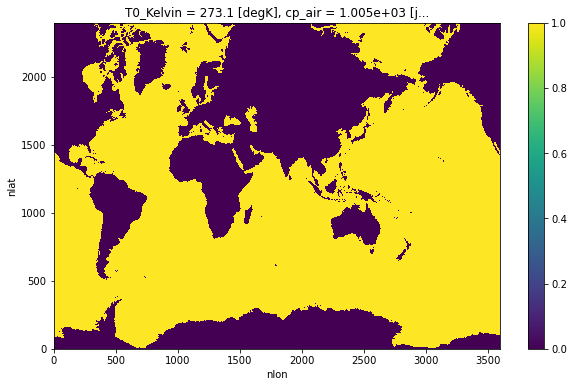

In [3]:
# create fields needed to apply the filter: wet mask and area
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''});

area = ds.TAREA / 10000  # convert units from cm2 to m2

Reorganizing the data by making 1 dask chunk in latitude and longitude direction. That way the chunks do not influence the spatial filtering.

In [8]:
wet_mask = wet_mask.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})
area = area.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})

#zonal velocity [cm/s]
u= ds.U1_1.where(wet_mask)
u = u.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})
u = u / 100 #to convert to [m/s]

#zonal velocity [cm/s]
v = ds.V1_1.where(wet_mask)
v = v.chunk({'nlat': len(ds.nlat), 'nlon': len(ds.nlon)})
v = v / 100 #to convert to [m/s]

In [6]:
u

<xarray.DataArray 'U1_1' (time: 16401, nlat: 2400, nlon: 3600)>
dask.array<truediv, shape=(16401, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
  * time                (time) object 2006-01-02 00:00:00 ... 2051-01-01 00:0...
    vonkar              float64 0.4
Dimensions without coordinates: nlat, nlon

### Creating and Applying the CGM filter with scalar Laplacians to the velocity fields

In [9]:
#filter specifications - 1 degrees scale
specs = {
    'filter_scale': 10,
    'dx_min': 1,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'grid_type': gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED
}

In [10]:
#create the filter
filter_10 = gcm_filters.Filter(grid_vars={'area': area, 'wet_mask': wet_mask}, **specs)
filter_10

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>)

In [11]:
#Apply the filter to the velocity fields
u_fil = filter_10.apply(u, dims=['nlat', 'nlon'])
v_fil = filter_10.apply(v, dims=['nlat', 'nlon'])
u_fil

<xarray.DataArray (time: 16401, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(16401, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 4.0
    sflux_factor        float64 0.1
    sound               float64 1.5e+05
    stefan_boltzmann    float64 5.67e-08
  * time                (time) object 2006-01-02 00:00:00 ... 2051-01-01 00:0...
    vonkar              float64 0.4
Dimensions without coordinates: nlat, nlon

### Mean Kinetic Energy and Eddy Kinetic Energy calculations using the velocity fields

KE = $\frac{1}{2} \left( u^2 + v^2 \right)$

MKE = $\frac{1}{2} \left( \overline{u}^2 + \overline{v}^2 \right)$

EKE = $\overline{KE} - MKE$

In [12]:
#Calculating Kinetic Energy (KE), Mean Kinetic Energy (MKE) 
#and Eddy Kinetic Energy (EKE) 
KE = 0.5*(u**2 + v**2)

MKE = 0.5*(u_fil**2 + v_fil**2).squeeze()
# this is the large scale kinetic energy

EKE = filter_10.apply(KE, dims=['nlat', 'nlon']).squeeze() - MKE
#this is the small scale kinetic energy

### Slicing and Plotting the results

In [13]:
lats = [1150,1550]
lons = [80,1400]

#Slicing the data
MKE_plot = MKE.isel(nlon=slice(*lons),nlat=slice(*lats),time=20)
m_MKE = MKE_plot.mean().values
s_MKE = MKE_plot.std().values

EKE_plot = EKE.isel(nlon=slice(*lons),nlat=slice(*lats),time=20)
m_EKE = EKE_plot.mean().values
s_EKE = EKE_plot.std().values

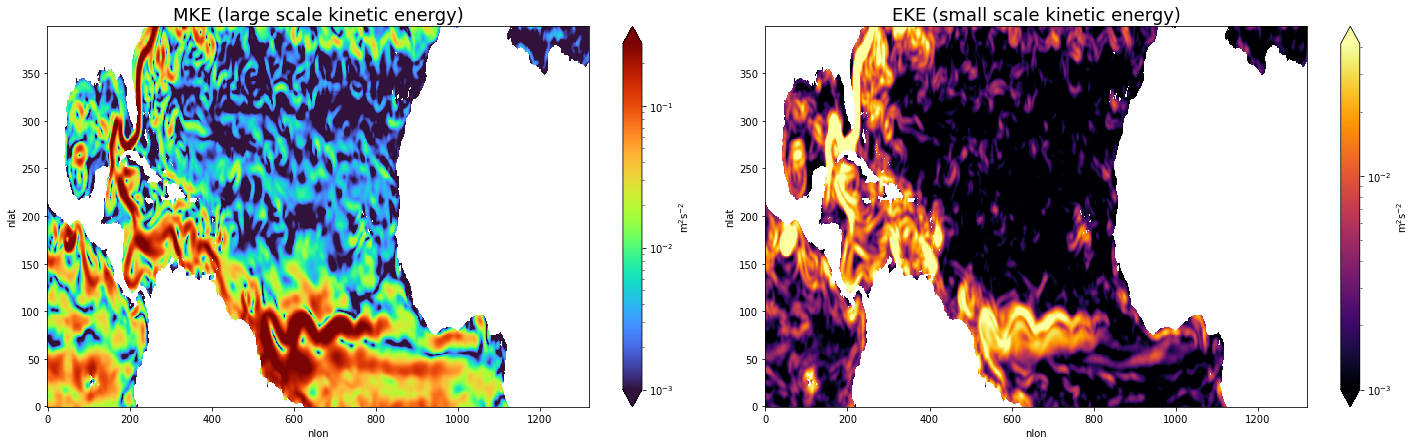

In [15]:
#plotting

fig,axs = plt.subplots(1,2,figsize=(25,7),sharex=True)

norm = colors.LogNorm(vmin=0.001, vmax=m_MKE+3*s_MKE) 

MKE_plot.plot.pcolormesh(
    ax=axs[0],
    norm=norm, cmap='turbo',
    cbar_kwargs={'label': r'm$^2$s$^{-2}$'},
    extend = 'both'
)

axs[0].set_title('MKE (large scale kinetic energy)', fontsize=18)

norm2 = colors.LogNorm(vmin=0.001, vmax=m_EKE+2*s_EKE)

EKE_plot.plot.pcolormesh(
    ax=axs[1], 
    norm=norm2, cmap='inferno',
    cbar_kwargs={'label': r'm$^2$s$^{-2}$'},
    extend = 'both'
)

axs[1].set_title('EKE (small scale kinetic energy)', fontsize=18)

plt.subplots_adjust(wspace=0.06)

plt.savefig("KE_NCAR_111km_log.png")

#### Using Cartopy with this dataset was a bit tricky

We had to expand a bit the wet mask we were using

In [16]:
pip install scikit-image #installing the package to do that

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 14.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Using erosion to expand the wet mask ever so slightly
from skimage.morphology import dilation, erosion, disk

mask_pop = xr.where(ds['KMT']>0, 1, 0)
mask_pop.data = erosion(mask_pop, selem=disk(1))

/tmp/ipykernel_3306/3092802324.py:5: FutureWarning: `selem` is a deprecated argument name for `erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  mask_pop.data = erosion(mask_pop, selem=disk(1))


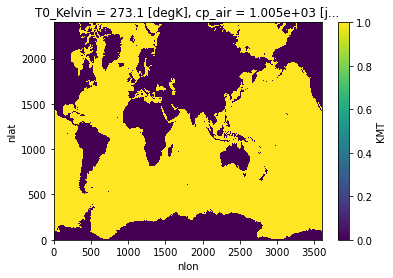

In [18]:
mask_pop.plot()

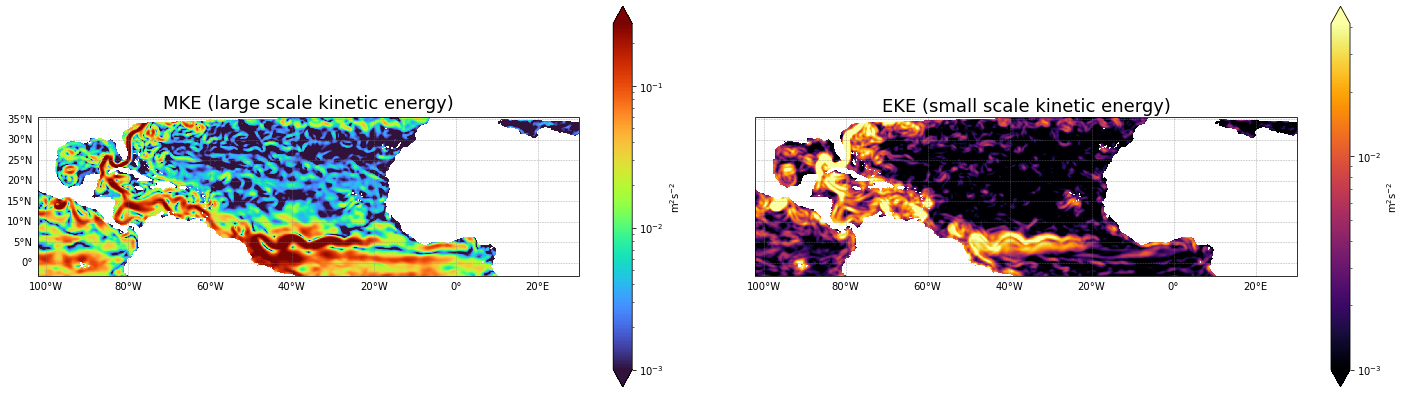

In [22]:
#Cartopy Proprieties
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pro = ccrs.PlateCarree() 
land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', 
            land_resolution, edgecolor='k', facecolor=cfeature.COLORS['land'])

fig2,ax = plt.subplots(1,2,figsize=(25,7),sharey=True, 
                       subplot_kw={'projection': pro})

MKE.where(mask_pop).isel(nlon=slice(*lons),nlat=slice(*lats),time=20).plot(
    x='TLONG',y='TLAT',ax=ax[0],
    transform=ccrs.PlateCarree(),
    norm=norm, cmap='turbo',
    cbar_kwargs={'label': r'm$^2$s$^{-2}$'},
    extend = 'both')

#ax[0].coastlines(resolution=land_resolution, color='black', linewidth=1)
#ax[0].add_feature(land_poly)
ax[0].set_title('MKE (large scale kinetic energy)', fontsize=18)

#Grid and axis
g = ax[0].gridlines(crs=pro, draw_labels=True, linewidth=0.5, zorder=100,
                     color='gray', alpha=0.7, linestyle='--')
g.top_labels= False
g.right_labels = False

EKE.where(mask_pop).isel(nlon=slice(*lons),nlat=slice(*lats),time=20).plot(
    x='TLONG',y='TLAT',ax=ax[1],
    transform=ccrs.PlateCarree(),
    norm=norm2, cmap='inferno',
    cbar_kwargs={'label': r'm$^2$s$^{-2}$'},
    extend = 'both')

#ax[0].coastlines(resolution=land_resolution, color='black', linewidth=1)
#ax[0].add_feature(land_poly)
ax[1].set_title('EKE (small scale kinetic energy)', fontsize=18)

#Grid and axis
g = ax[1].gridlines(crs=pro, draw_labels=True, linewidth=0.5, zorder=100,
                     color='gray', alpha=0.7, linestyle='--')
g.top_labels= False
g.right_labels = False
g.left_labels = False

plt.subplots_adjust(wspace=0.06)

plt.savefig("KE_NCAR_111km_log_cartopy.png")


### Movie

In [ ]:
EKE_movie = EKE.isel(nlon=slice(*lons),nlat=slice(*lats),time=slice(None, 10))

In [ ]:
mov = Movie(EKE_movie, 
            norm=norm, cmap='inferno',
            cbar_kwargs={'label': 'J'},
            extend = 'both',
            plotmethod='pcolormesh',
            framedim='time')

In [ ]:
mov.save('movie.gif', gif_framerate=3, overwrite_existing=True)

# Next Steps

- **Make Movies!**: See how the EKE evolves on longer time scales

- Compare the filtering of the velocity fields using the filter with scalar laplacian and vector laplacian 

- Use the tools that we learn in our future work (Ex: Use GitHub to help our workflow)